In [1]:
from toolbox import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u_arr = ecdf_brr(data.return_brr)
v_arr = ecdf_btc(data.return_btc)


In [2]:
alpha = 1
beta = 0
mu = 0
delta = 1
delta1 = 1
size = 1000

Z_law = norminvgauss(alpha, beta, mu, delta)
Z1_law = norminvgauss(alpha, beta, mu, delta1)
Z2_law = norminvgauss(alpha, beta, mu, delta1)

Z  = Z_law.rvs(size)
X1 = Z + Z1_law.rvs(size)
X2 = Z + Z2_law.rvs(size)

X1_law = norminvgauss(alpha, beta, mu, delta+delta1)
X2_law = norminvgauss(alpha, beta, mu, delta+delta1)

scipy.stats.kendalltau(X1, X2)

KendalltauResult(correlation=0.34523323323323324, pvalue=4.5514167001818863e-60)

In [3]:
scipy.stats.spearmanr(X1,X2)

SpearmanrResult(correlation=0.49152694752694753, pvalue=6.0115952401565014e-62)

In [133]:
delta1_arr = np.linspace(.01,10,100)
alpha_arr = np.array([0.1,0.2,0.5,1,2,5,10])

tau = np.zeros((len(delta1_arr), len(alpha_arr)))

beta = 0
mu = 0
delta = 1
# delta1 = 1
size = 100000
Z  = Z_law.rvs(size)

for i in range(len(delta1_arr)):
    for j in range(len(alpha_arr)):
        alpha = alpha_arr[j]
        delta1 = delta1_arr[i]
        
        Z_law = norminvgauss(alpha, beta, mu, delta)
        Z1_law = norminvgauss(alpha, beta, mu, delta1)
        Z2_law = norminvgauss(alpha, beta, mu, delta1)

        X1 = Z + Z1_law.rvs(size)
        X2 = Z + Z2_law.rvs(size)

        X1_law = norminvgauss(alpha, beta, mu, delta+delta1)
        X2_law = norminvgauss(alpha, beta, mu, delta+delta1)

#         tau[i,j] = scipy.stats.kendalltau(X1, X2)[0]
        tau[i,j] = scipy.stats.spearmanr(X1,X2)[0]

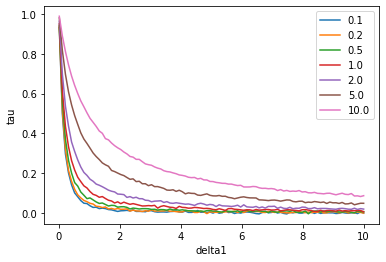

In [134]:
for j in range(len(alpha_arr)):
    plt.plot(delta1_arr, tau[:,j], label=alpha_arr[j])
    
plt.xlabel('delta1')
plt.ylabel('tau')
plt.legend()

In [179]:
# u=.9999
# v=.9999
q=0.9
u=v=q
a = X1_law.ppf(u)
b = X2_law.ppf(v)
fn = lambda z: Z1_law.cdf(a-z)*Z2_law.cdf(b-z)*Z_law.pdf(z)
scipy.integrate.quad(fn, -np.inf, np.inf)[0]/q

0.9033803622365268

In [180]:
np.mean( ((u_arr < q) & (v_arr < q))/q)

0.9560723514211884

In [156]:
%%time
for _ in range(10):
    a = X1_law.ppf(u)
    b = X2_law.ppf(v)
    fn = lambda z: Z1_law.pdf(a-z)*Z2_law.pdf(b-z)*Z_law.pdf(z)
    scipy.integrate.quad(fn, -np.inf, np.inf)[0]

CPU times: user 2.72 s, sys: 14.6 ms, total: 2.74 s
Wall time: 2.74 s


In [150]:
fn = lambda z: Z1_law.pdf(a-z)*Z2_law.pdf(b-z)*Z_law.pdf(z)

In [155]:
Z1_law.pdf(u)

0.3527462262325758

In [4]:
alpha = 1
beta = 0
mu = 0
delta = 1
deltai = 1
class NIG_factor():
    def __init__(self, alpha, beta, deltai):
        self.alpha  = alpha
        self.beta   = beta
        self.mu     = 0
        self.delta  = 1
        self.deltai = deltai
        
        self.Z_law  = norminvgauss(self.alpha, self.beta, self.mu, self.delta)
        self.Zi_law = norminvgauss(self.alpha, self.beta, self.mu, self.deltai)
        self.Xi_law = norminvgauss(self.alpha, self.beta, self.mu, self.delta+self.deltai)

    def C(self, u, v): # Copula funcion
        a = self.Xi_law.ppf(u)
        b = self.Xi_law.ppf(v)
        fn = lambda z: self.Zi_law.cdf(a-z)*self.Zi_law.cdf(b-z)*self.Z_law.pdf(z)
        return scipy.integrate.quad(fn, -np.inf, np.inf)[0]
    
    def _lambda(self, q):
        if q<= 0.5:
            return self.C(q,q)/q
        else:
            return (1-(2*q)+self.C(q,q) )/(1-q)
        
    def sample(self, size):
        Z  = self.Z_law.rvs(size)
        X1 = Z + self.Zi_law.rvs(size)
        X2 = Z + self.Zi_law.rvs(size)
        
#         u = [self.Xi_law.cdf(x1) for x1 in X1]
#         v = [self.Xi_law.cdf(x2) for x2 in X2]

#         u = rankdata(X1)/len(X1)
#         v = rankdata(X2)/len(X2)

        u = ECDF(X1)(X1)
        v = ECDF(X2)(X2)
        return np.array([u,v])

In [354]:
true = np.array([X1_law.cdf(x1) for x1 in X1])

In [293]:
factor_copula = NIG_factor(0.05,0,0.4)
factor_copula._lambda(0.1)

0.6345139162981578

In [284]:
q=0.9
print(factor_copula._lambda(q), 
empirical_lambda(u_arr, v_arr, q))

0.5533791010751444 0.6201550387596901


In [490]:
result

array([7.23418894e+01, 6.91726231e-04, 1.21733789e-01])

In [80]:
round(len(s[0,:])/20)

500

[]

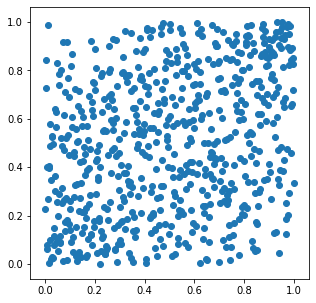

In [507]:
# factor_copula = NIG_factor(result[0]/20, result[1], result[2]*3)
# factor_copula = NIG_factor(0.5,0,0.5)
# factor_copula = NIG_factor(result[0], result[1], result[2])
factor_copula = NIG_factor(3.1354, 0.121548, 2.53221)

s = factor_copula.sample(len(u_arr))
plt.figure(figsize=(5,5))
plt.scatter(s[0,:], s[1,:])
# plt.hist2d(s[0,:],s[1,:], bins=20)
plt.plot()

[]

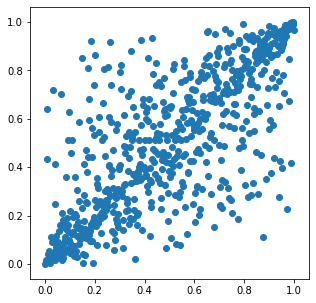

In [493]:
plt.figure(figsize=(5,5))
plt.scatter(u_arr, v_arr)
# plt.hist2d(u_arr,v_arr, bins=20)
plt.plot()

In [568]:
q=.4
print(np.mean( (s[0,:]<q) & (s[1,:]>(1-q)) ) ,
np.mean( (u_arr<q) & (v_arr>(1-q)) )  )

print(np.mean( (s[0,:]>(1-q)) & (s[1,:]<q) ) ,
np.mean( (u_arr>(1-q)) & (v_arr<q) )  )

0.04806201550387597 0.04496124031007752
0.05116279069767442 0.05116279069767442


In [546]:
print(np.mean( (s[0,:]>(1-q)) & (s[1,:]<q) ) ,
np.mean( (u_arr>(1-q)) & (v_arr<q) )  )

0.03255813953488372 0.05116279069767442


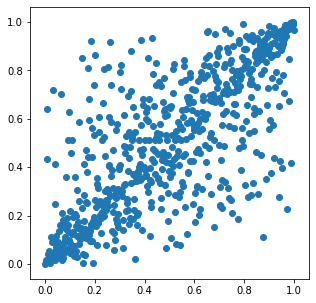

In [485]:
plt.figure(figsize=(5,5))
plt.scatter(u_arr, v_arr)

In [488]:
empirical_rho_s = scipy.stats.pearsonr(u_arr,v_arr)[0]
q_arr = [0.01,0.1,0.2,0.5,0.8,0.9,0.99]

empirical_lambda_0 = empirical_lambda(u_arr, v_arr, q_arr[0])
empirical_lambda_1 = empirical_lambda(u_arr, v_arr, q_arr[1])
empirical_lambda_2 = empirical_lambda(u_arr, v_arr, q_arr[2])
empirical_lambda_3 = empirical_lambda(u_arr, v_arr, q_arr[3])
empirical_lambda_4 = empirical_lambda(u_arr, v_arr, q_arr[4])
empirical_lambda_5 = empirical_lambda(u_arr, v_arr, q_arr[5])
empirical_lambda_6 = empirical_lambda(u_arr, v_arr, q_arr[6])

def SMM_loss(alpha, beta, deltai):
    if np.abs(beta) >= alpha:
        return 5000    
    if deltai<0:
        return 5000
    factor_copula = NIG_factor(alpha,beta,deltai)
    s = factor_copula.sample(500000)
    part0 = ( empirical_rho_s    - scipy.stats.pearsonr(s[0,:],s[1,:])[0]     )**2
    part1 = ( empirical_lambda_0 - empirical_lambda(s[0,:], s[1,:], q_arr[0]) )**2
    part2 = ( empirical_lambda_1 - empirical_lambda(s[0,:], s[1,:], q_arr[1]) )**2
    part3 = ( empirical_lambda_2 - empirical_lambda(s[0,:], s[1,:], q_arr[2]) )**2
    part4 = ( empirical_lambda_2 - empirical_lambda(s[0,:], s[1,:], q_arr[3]) )**2
    part5 = ( empirical_lambda_2 - empirical_lambda(s[0,:], s[1,:], q_arr[4]) )**2
    part6 = ( empirical_lambda_2 - empirical_lambda(s[0,:], s[1,:], q_arr[5]) )**2
    part7 = ( empirical_lambda_2 - empirical_lambda(s[0,:], s[1,:], q_arr[6]) )**2
    return part0+part1+part2+part3+part4+part5+part6+part7
#     return part0+part1+part3

fn = lambda x: SMM_loss(alpha=x[0],beta=x[1],deltai=x[2])
x0 = (50,0,.5)
# x0 = {'alpha':1, 'beta':0, 'deltai':1}
# fn(x0)
# scipy.optimize.minimize(fn, x0=x0, bounds = ((10,100),(0,100),(0,10)))
result = scipy.optimize.fmin(fn, x0=x0,
                             ftol=0.01,
                             maxiter=20000, maxfun=10000)

Optimization terminated successfully.
         Current function value: 0.076640
         Iterations: 55
         Function evaluations: 133


In [505]:
print('Empricial', 'Copula')
print(q_arr[0], empirical_lambda_0, empirical_lambda(s[0,:], s[1,:],q_arr[0]))
print(q_arr[1], empirical_lambda_1, empirical_lambda(s[0,:], s[1,:],q_arr[1]))
print(q_arr[2], empirical_lambda_2, empirical_lambda(s[0,:], s[1,:],q_arr[2]))
print(q_arr[3], empirical_lambda_3, empirical_lambda(s[0,:], s[1,:],q_arr[3]))
print(q_arr[4], empirical_lambda_4, empirical_lambda(s[0,:], s[1,:],q_arr[4]))


Empricial Copula
0.01 0.46511627906976744 0.15503875968992248
0.1 0.6356589147286822 0.5426356589147286
0.2 0.7209302325581395 0.6356589147286822
0.5 0.7503875968992249 0.7441860465116279
0.8 0.6589147286821707 0.6356589147286823


In [506]:
len(data)

645

In [491]:
result

array([7.23418894e+01, 6.91726231e-04, 1.21733789e-01])

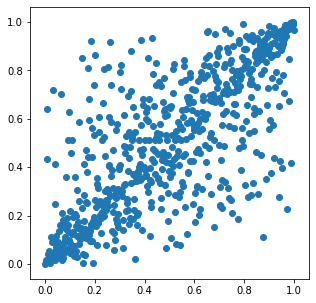

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(u_arr, v_arr)

QEP stands for Quantile Exceedence Probability. In bivariate case, we define four QEPs for the four quadrants of a unit square $[0,1]^2$.

First Quadrant Quantile Exceedence Probability

$QEP_1(q) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}(u_i \leq q \phantom{1-}, v_i > 1-q) $

$QEP_2(q) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}(u_i > 1-q, v_i > 1-q) $

$QEP_3(q) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}(u_i \leq q\phantom{1-}, v_i \leq q) $

$QEP_4(q) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}(u_i > 1-q, v_i \leq q) $

where $u_i = F_X(x_i)$ and $v_i = F_Y(y_i)$.

$QEP_2$ and $QEP_3$ are known as joint quantile exceedane probabilities in (McNeil et al, 2005, p. 212) . 


In [384]:
q=0.3

def QEPs(u,v,q):
    empricial_QEP_1 = np.mean( (u <=  q) & (v > 1-q) )
    empricial_QEP_2 = np.mean( (u > 1-q) & (v > 1-q) ) #Upper
    empricial_QEP_3 = np.mean( (u <=  q) & (v <=  q) ) #Lower
    empricial_QEP_4 = np.mean( (u > 1-q) & (v <=  q) ) 
    return np.array([[empricial_QEP_1], 
                     [empricial_QEP_2], 
                     [empricial_QEP_3],
                     [empricial_QEP_4]])

np.sum( (QEPs(u_arr, v_arr, 0.5) - QEPs(s[0,:], s[1,:], 0.5) )**2 )

0.0008172585782104452

In [386]:
q=0.4
# q1=0.1
m1 = (QEPs(s[0,:], s[1,:], q)-QEPs(u_arr, v_arr, q) )
# m2 = (QEPs(s[0,:], s[1,:], q1)-QEPs(u_arr, v_arr, q1) )

# QEPs(u_arr, v_arr, q) - QEPs(s[0,:], s[1,:], q)
k = np.linalg.inv(np.linalg.inv(m1.dot(m1.T)))
# m1.dot(m1.T)
# np.linalg.det(m1.dot(m1.T))
# np.linalg.inv(m1.dot(m1.T))

LinAlgError: Singular matrix

In [426]:

def SMM_loss2(alpha, beta, deltai):
    if np.abs(beta) >= alpha:
        return 5000    
    if deltai<0:
        return 5000
    factor_copula = NIG_factor(alpha,beta,deltai)
    s = factor_copula.sample(500000) 
    q_arr =  [0.5,0.4,0.3,0.2,0.1,0.01]
    g =  ([(QEPs(s[0,:], s[1,:], q)-QEPs(u_arr, v_arr, q) ) for q in q_arr])
    g = np.concatenate(g, axis=0)
    return g.T.dot(g)[0][0]


SMM_loss2(0.5,0,0.5)

0.003684379150823872

In [427]:
fn = lambda x: SMM_loss2(alpha=x[0],beta=x[1],deltai=x[2])
x0 = (0.1,0,0.5)
result = scipy.optimize.fmin(fn, x0=x0,
                             ftol=0.0002,
                             maxiter=20000, maxfun=10000)

Optimization terminated successfully.
         Current function value: 0.000514
         Iterations: 27
         Function evaluations: 67


In [405]:

def SMM_loss1(alpha, beta, deltai):
    if np.abs(beta) >= alpha:
        return 5000    
    if deltai<0:
        return 5000
    factor_copula = NIG_factor(alpha,beta,deltai)
    s = factor_copula.sample(500000)
    
    parts = []
    q_arr = [0.5,0.4,0.3,0.2,0.1,0.01]
    for q in q_arr:
        parts.append( np.sum( (QEPs(u_arr, v_arr, q) - QEPs(s[0,:], s[1,:], q))**2))
    return np.sum(parts)
#     part1 = np.sum( (QEPs(u_arr, v_arr, 0.50) - QEPs(s[0,:], s[1,:], 0.50) )**2 )
#     part2 = np.sum( (QEPs(u_arr, v_arr, 0.40) - QEPs(s[0,:], s[1,:], 0.45) )**2 )
#     part3 = np.sum( (QEPs(u_arr, v_arr, 0.30) - QEPs(s[0,:], s[1,:], 0.40) )**2 )
#     part4 = np.sum( (QEPs(u_arr, v_arr, 0.20) - QEPs(s[0,:], s[1,:], 0.35) )**2 )  
#     return part1+part2+part3+part4

alpha_arr = [10,1,0.1,0.01]
for alpha in alpha_arr:
    print(SMM_loss1(0.1,0,0.3))

0.001902998494451777
0.001915079332870377
0.001954601050017667
0.0018071918898316206


In [62]:
fn = lambda x: SMM_loss1(alpha=x[0],beta=x[1],deltai=x[2])
x0 = (0.1,0,0.5)
result = scipy.optimize.fmin(fn, x0=x0,
                             ftol=0.0002,
                             maxiter=20000, maxfun=10000)

Optimization terminated successfully.
         Current function value: 0.000520
         Iterations: 26
         Function evaluations: 64


In [63]:
print(result)
(fn(result))

[1.16767059e-01 3.49584072e-04 3.66164349e-01]


0.0005483601602812336

In [326]:
loss_arr = []
alpha_arr = np.linspace(0.1,50,10)
for alpha in alpha_arr:
    loss_arr.append(SMM_loss(alpha,0,0.5))

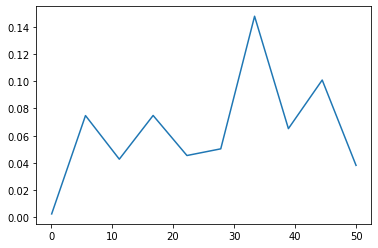

In [327]:
plt.plot(alpha_arr, loss_arr)

In [254]:
q_arr = [0.1,0.5,0.9]

def empirical_lambda(u_arr, v_arr, q):
    if q <=0.5:
        return np.mean( ((u_arr <= q) & (v_arr <= q))/q)
    else:
        return np.mean( ((u_arr > q) & (v_arr > q))/(1-q) )
    
empirical_lambda_0 = empirical_lambda(u_arr, v_arr, q_arr[0])
empirical_lambda_1 = empirical_lambda(u_arr, v_arr, q_arr[1])
empirical_lambda_2 = empirical_lambda(u_arr, v_arr, q_arr[2])

def loss(alpha, beta, deltai):
    if np.abs(beta) >= alpha:
        return 5000    
    if deltai<0:
        return 5000
    factor_copula = NIG_factor(alpha, beta, deltai)
    part1 = (empirical_lambda_0 - factor_copula._lambda(q_arr[0]) ) **2
    part2 = (empirical_lambda_1 - factor_copula._lambda(q_arr[1]) ) **2
    part3 = (empirical_lambda_2 - factor_copula._lambda(q_arr[2]) ) **2
    return part1 + part2 + part3

In [221]:
print(empirical_lambda_0, 
      empirical_lambda_1, 
      empirical_lambda_2)

0.6356589147286822 0.7503875968992249 0.6201550387596901


In [218]:
print(loss(1,1,1), loss(1,0,-10))

5000 5000


In [297]:
fn = lambda x: loss(alpha=x[0],beta=x[1],deltai=x[2])
x0 = (9,0,9)
# x0 = {'alpha':1, 'beta':0, 'deltai':1}
scipy.optimize.minimize(fn, x0=x0, bounds = ((0,10),(0,10),(0,10)))

/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:100: RuntimeWarning: invalid value encountered in double_scalars
  return part1*part2*part4/part3
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the i

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:100: RuntimeWarning: invalid value encountered in double_scalars
  return part1*part2*part4/part3
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The maximum number of subdivisions

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze

/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Dri

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved

/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:100: RuntimeWarning: invalid value encountered in double_scalars
  return part1*part2*part4/part3
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the i

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:100: RuntimeWarning: invalid value encountered in double_scalars
  return part1*part2*part4/part3
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If th

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:100: RuntimeWarning: invalid value encountered in double_scalars
  return part1*part2*part4/part3
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22:

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:100: RuntimeWarning: invalid value encountered in double_scalars
  return part1*part2*part4/part3
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The maximum number of subdivisions

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze

/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Dri

KeyboardInterrupt: 

In [271]:
alpha_arr = np.linspace(.05,.1,10)
loss_result = []
for alpha in alpha_arr:
    loss_result.append( loss(alpha,0,0.5) )
    print(alpha)

/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.05


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.05555555555555556


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.061111111111111116


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.06666666666666667


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.07222222222222223


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.07777777777777778


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.08333333333333334


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.08888888888888889


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.09444444444444444


/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


0.1


In [285]:
q_arr = [0.1,0.5,0.9]

def empirical_lambda(u_arr, v_arr, q):
    if q <=0.5:
        return np.mean( ((u_arr <= q) & (v_arr <= q))/q)
    else:
        return np.mean( ((u_arr > q) & (v_arr > q))/(1-q) )
    
empirical_lambda_0 = empirical_lambda(u_arr, v_arr, q_arr[0])
empirical_lambda_1 = empirical_lambda(u_arr, v_arr, q_arr[1])
empirical_lambda_2 = empirical_lambda(u_arr, v_arr, q_arr[2])

def loss(alpha, beta, deltai):
    if beta >= alpha:
        return 5000    
    if deltai<0:
        return 5000
    factor_copula = NIG_factor(alpha, beta, deltai)
    part1 = (empirical_lambda_0 - factor_copula._lambda(q_arr[0]) ) **2
#     part2 = (empirical_lambda_1 - factor_copula._lambda(q_arr[1]) ) **2
#     part3 = (empirical_lambda_2 - factor_copula._lambda(q_arr[2]) ) **2
#     return part1 + part2 + part3
    return part1

In [286]:
fn = lambda x: loss(alpha=x[0],beta=x[1],deltai=x[2])
x0 = (1,0,1)
# x0 = {'alpha':1, 'beta':0, 'deltai':1}
scipy.optimize.minimize(fn, x0=x0, bounds = ((0,10),(0,10),(0,10)))

/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(self.pdf, -np.inf, y)[0]


KeyboardInterrupt: 

In [591]:
from copulae import *

C = Clayton(theta=10, Law_RS=stats.norm, Law_RF=stats.norm)

In [616]:
q_arr = [0.0000000000000000000000001,0.1,0.2,0.3,0.4]
for q in q_arr:
    print(1-C.copula_fn(q,1-q)/q)

3.219646771412954e-15
1.8679724433923184e-11
8.512739191335328e-08
2.031137316338416e-05
0.0017075211375202626


In [610]:
q=.99999
C.copula_fn(q,1-q)/q

1.0000100000954492e-05

In [587]:
C.meta_t.cdf((C.t1.ppf(0), C.t2.ppf(1)))

KeyboardInterrupt: 

In [619]:
0/0

ZeroDivisionError: division by zero